In [1]:
import numpy as np
import theano
import theano.tensor as T
from theano import function as F
import theano.tensor.nnet as NN
from matplotlib import pyplot as plt

%matplotlib inline

"Couldn't import dot_parser, loading of dot files will not be possible."と出るのはpydotがpyparse1.x系を
期待しているからだそうで、対処法は[こちら](http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will)。

テンソルのシンボルを作成して、シンボル同士で演算してグラフをつくり、グラフを関数にコンパイル、という流れだそうだ。

In [2]:
x=T.dscalar("x")
y=T.dscalar("y")
z= x+y
f=F([x,y],z)

In [3]:
f(2,3)

array(5.0)

演算グラフ表示。[こちら](http://sinhrks.hatenablog.com/entry/2015/04/25/233025)参考。

In [4]:
import IPython.display as display

def plot_graph(obj):
    svg = theano.printing.pydotprint(obj, return_image=True, format='svg')
    return display.SVG(svg)

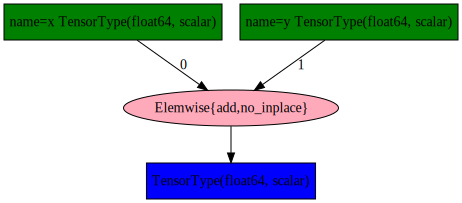

In [5]:
plot_graph(f)

グラフ時点で微分が行える。

In [6]:
y=x**2
dy = F([x],T.grad(y, x))

In [7]:
dy(2)

array(4.0)

MNISTやってみる。データはtensorflowのexampleから取得。

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
print np.shape(mnist.train.images)
print np.shape(mnist.train.labels)

(55000, 784)
(55000, 10)


In [10]:
MAX_DATA=55000
def get_batch(n):
    ni=np.random.randint(0,MAX_DATA,n)
    x = mnist.train.images[ni] 
    y = mnist.train.labels[ni]
    return x,y

なるべくChainerっぽく記述してみる。
係数の初期化はChainerのマネをした。
わかりにくいのはdimshuffleの下り。バイアスを足す時点で、ベクタを４階テンソルに置き換え、
ベクタの方向を２階目に割り振る、というのがdimshuffle('x',0,'x','x')らしい。
reshape(batch_num,-1,ksize,ksize)というかんじか。

In [24]:
from theano.tensor.signal import pool
from theano import pp

def CRP(input,in_dim,out_dim,name=""):
    '''
    Conv2d, Relu, and maxPool_2d
    '''
    ksize=3
    initialW = np.random.normal(0, np.sqrt(1.0/(in_dim* ksize**2)), (out_dim,in_dim, ksize, ksize))    
    W = theano.shared(initialW,name=name+"_W")
    b = theano.shared(np.zeros((out_dim)), name=name+"_b")
    h1 = NN.conv2d(input,W,border_mode="half")+b.dimshuffle('x', 0,'x','x')
    h2 = NN.relu(h1)
    h3 = pool.pool_2d(h2, (2,2),ignore_border=False)
    return h3, [W,b]

def LIN(x,in_dim, out_dim , name=""):
    '''
    LINear function,  y=xW+b
    '''
    initialW = np.random.normal(0, np.sqrt(1. / (in_dim)), (in_dim, out_dim))    
    W = theano.shared(initialW,name=name+"_W")
    b = theano.shared(np.zeros((out_dim)), name=name+"_b")
    h = theano.dot(x,W)+ b.dimshuffle('x', 0)
    return h,[W,b]

class myLink():
    def __init__(self, learning_rate=0.01):
        x = T.tensor4("x")  # Input images:  batch x channel x width x height
        y = T.lvector("y")   # Labels:              batch x label

        # Network definition
        h1,p1 = CRP(x,1,16,"C1")                    #  outputs batch_num x 16ch x (14x14)
        h2,p2 = CRP(h1,16,64,  "C2")             #  outputs batch_num x 64ch x (7x7)
        h3,p3 = CRP(h2,64,256,"C3")             #  outputs batch_num x 256ch x (4x4)
        f3 = T.flatten(h3,2)                               # outputs batch_num x (256*4*4)
        h4,p4 = LIN(f3,256*4*4,512, "L1")  #  outputs batch_num x 512
        h5,p5 = LIN(h4,512,10, "L2")             #  outputs batch_num x 10
        y_pred = NN.softmax(h5)

        # cost and gradients
        cost = T.mean(NN.categorical_crossentropy(y_pred, y))        
        params=p1+p2+p3+p4+p5
        grads = T.grad(cost, params)   
        
        # SGD
        updates = [
            (param_i, param_i - learning_rate * grad_i)
            for param_i, grad_i in zip(params, grads)
        ]
        
        # define & compile update/predict function
        self.update_func =  theano.function([x,y], cost,updates=updates)
        self.pred_func =  theano.function([x], y_pred)        

    def show(self):
        plot_graph(self.cost)

    def update(self,batch_x,batch_y):
        return self.update_func( batch_x,batch_y)
        
    def pred(self,x):
        return self.pred_func(x)


学習ループ。

In [33]:
link=myLink(0.01) # SGD learning rate=0.01

batch_num=100
i=0
while(i<200):
    i+=1
    img,label=get_batch(batch_num)
    img=img.reshape((batch_num,1,28,28))
    label=np.argmax(label,axis=1).astype(np.int).reshape((batch_num))
    cost = link.update(img,label )
    if i%10==0:
        print cost

2.15261916086
1.99772690701
1.87746025553
1.74132082725
1.58069936618
1.42255544395
1.15643615209
0.992644069104
0.98299866398
0.875299245936
1.02978199035
0.785021946601
0.68131798228
0.699897691654
0.639099696439
0.731150598192
0.570754876758
0.517859172418
0.491013793568
0.656763339547


7

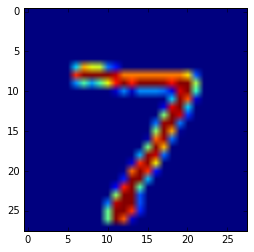

In [34]:
plt.imshow(mnist.test.images[0].reshape(28,28))
np.argmax(link.pred(mnist.test.images[0].reshape(1,1,28,28)))

ほかのフレームワークと　の違いはいろいろあるけど、印象的なのは、
- コンパイル済の関数はnp.array()を直接受けられる。
- オプティマイザは関数とセットにしてコンパイルする。
というあたりか。自前ですべて記述するひと